# Analyse a sequence of CTH images

In [1]:
import os
import requests
import bz2
from urllib.parse import urljoin
from bs4 import BeautifulSoup

# Target directory and base URL
base_url = "https://opendata.dwd.de/weather/satellite/clouds/CTH/"
download_dir = "cth_data"
os.makedirs(download_dir, exist_ok=True)

# Get the list of all files
response = requests.get(base_url)
soup = BeautifulSoup(response.text, "html.parser")
file_links = sorted([
    link.get("href") for link in soup.find_all("a")
    if link.get("href", "").endswith(".nc.bz2")
])

# Select latest 5 files
latest_files = file_links[-5:]

# Download and extract
for filename in latest_files:
    bz2_path = os.path.join(download_dir, filename)
    nc_path = bz2_path[:-4]

    # Download only if not yet present
    if not os.path.exists(bz2_path):
        print(f"Downloading {filename}...")
        url = urljoin(base_url, filename)
        with requests.get(url, stream=True) as r:
            with open(bz2_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

    # Extract .bz2 to .nc if needed
    if not os.path.exists(nc_path):
        print(f"Extracting {filename}...")
        with bz2.BZ2File(bz2_path, "rb") as f_in, open(nc_path, "wb") as f_out:
            f_out.write(f_in.read())

print("✅ Download and extraction complete.")


Extracting CTHin202504061515.nc.bz2...
Extracting CTHin202504061530.nc.bz2...
Extracting CTHin202504061545.nc.bz2...
Extracting CTHin202504061600.nc.bz2...
Extracting CTHin202504061615.nc.bz2...
✅ Download and extraction complete.


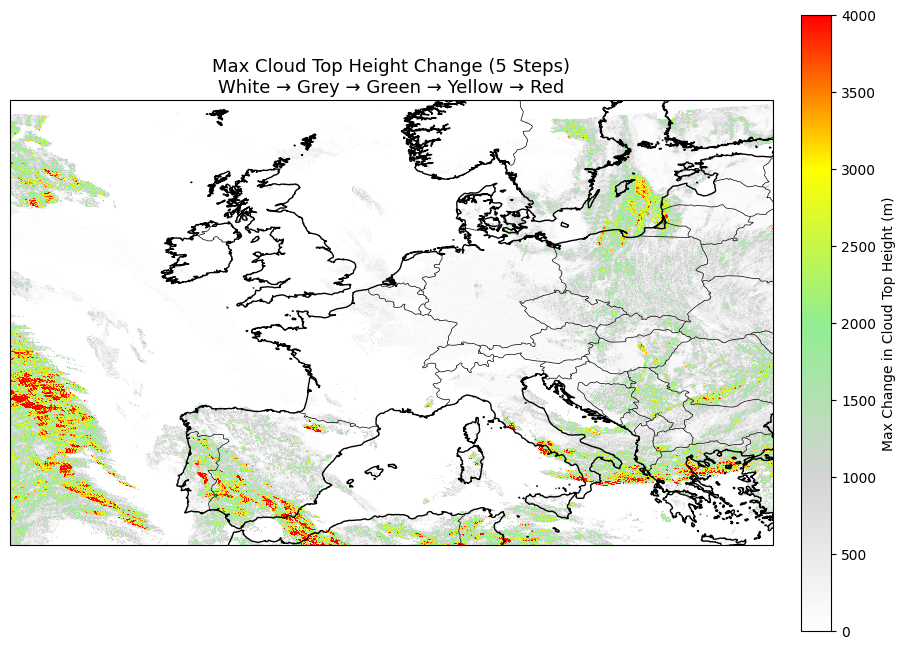

In [8]:
import netCDF4 as nc
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Directory with CTH .nc files
nc_dir = "cth_data"
nc_files = sorted([f for f in os.listdir(nc_dir) if f.endswith(".nc")])[:5]

# Load and stack CTH images
cth_list = []
lat = lon = None  # to be loaded once

for fname in nc_files:
    path = os.path.join(nc_dir, fname)
    ds = nc.Dataset(path)
    
    if lat is None:
        lat = ds.variables["lat"][:]
        lon = ds.variables["lon"][:]
    
    cth = ds.variables["CTH"][0, :, :]
    cth = np.ma.masked_where(cth <= 0, cth)
    cth_list.append(cth)
    ds.close()

# Stack to 3D array: (time, lat, lon)
cth_stack = np.ma.stack(cth_list)

# Compute max change across time steps
diffs = np.ma.abs(np.diff(cth_stack, axis=0))  # shape: (4, lat, lon)
max_change_map = np.ma.max(diffs, axis=0)

# Custom colormap: white → grey → green → yellow → red
colors = ["white", "lightgray", "lightgreen", "yellow", "red"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cth", colors, N=256)

# Meshgrid for plotting
lon2d, lat2d = np.meshgrid(lon, lat)

# Plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

plot = ax.pcolormesh(lon2d, lat2d, max_change_map, cmap=custom_cmap, shading="auto", vmax=4000)

ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title("Max Cloud Top Height Change (5 Steps)\nWhite → Grey → Green → Yellow → Red", fontsize=13)

cbar = plt.colorbar(plot, orientation='vertical', pad=0.03)
cbar.set_label("Max Change in Cloud Top Height (m)")

plt.savefig("cth_max_change_map.png", dpi=150)
plt.show()


In [9]:
import matplotlib.animation as animation
from IPython.display import HTML

# Setup figure and axis
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title("Cloud Top Height (CTH) Sequence")

# Create meshgrid
lon2d, lat2d = np.meshgrid(lon, lat)

# Plot initial frame
cmap_cth = plt.get_cmap("viridis")
cth_plot = ax.pcolormesh(lon2d, lat2d, cth_stack[0], cmap=cmap_cth, shading="auto", vmin=0, vmax=16000)
cbar = plt.colorbar(cth_plot, ax=ax, orientation='vertical', pad=0.03)
cbar.set_label("Cloud Top Height (m)")

# Update function for animation
def update_frame(i):
    ax.set_title(f"Cloud Top Height at Step {i+1}")
    cth_plot.set_array(cth_stack[i].ravel())
    return cth_plot,

# Create animation
ani = animation.FuncAnimation(
    fig, update_frame, frames=len(cth_stack),
    interval=800, blit=False, repeat=True
)

plt.close()  # Prevent static display

# Display in notebook
HTML(ani.to_jshtml())

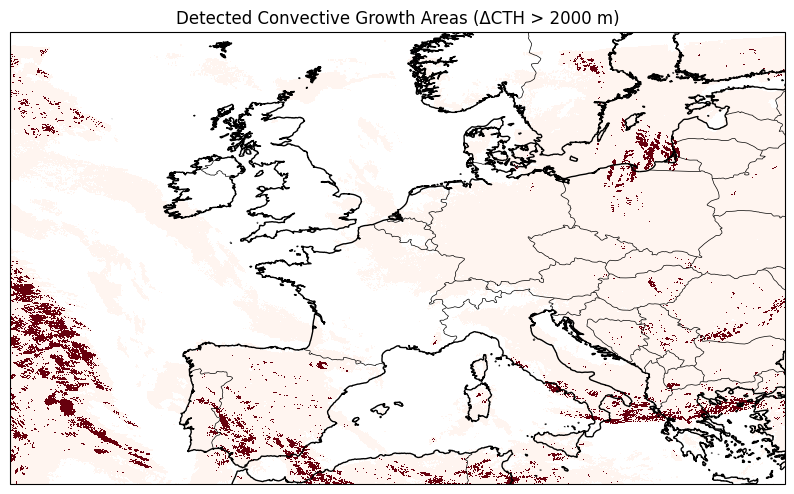

In [10]:
# Compute time differences
diffs = np.diff(cth_stack, axis=0)  # (steps-1, lat, lon)

# Keep only positive changes (upward growth)
growth = np.ma.maximum(diffs, 0)

# Compute max upward growth per pixel
max_growth = np.ma.max(growth, axis=0)

# Threshold for strong upward motion (e.g. >2000 m)
convective_mask = max_growth > 2000

# Plot where potential convection is occurring
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title("Detected Convective Growth Areas (ΔCTH > 2000 m)")

lon2d, lat2d = np.meshgrid(lon, lat)
ax.pcolormesh(lon2d, lat2d, convective_mask, cmap="Reds", shading="auto")

plt.savefig("cth_convective_growth.png", dpi=150)
plt.show()

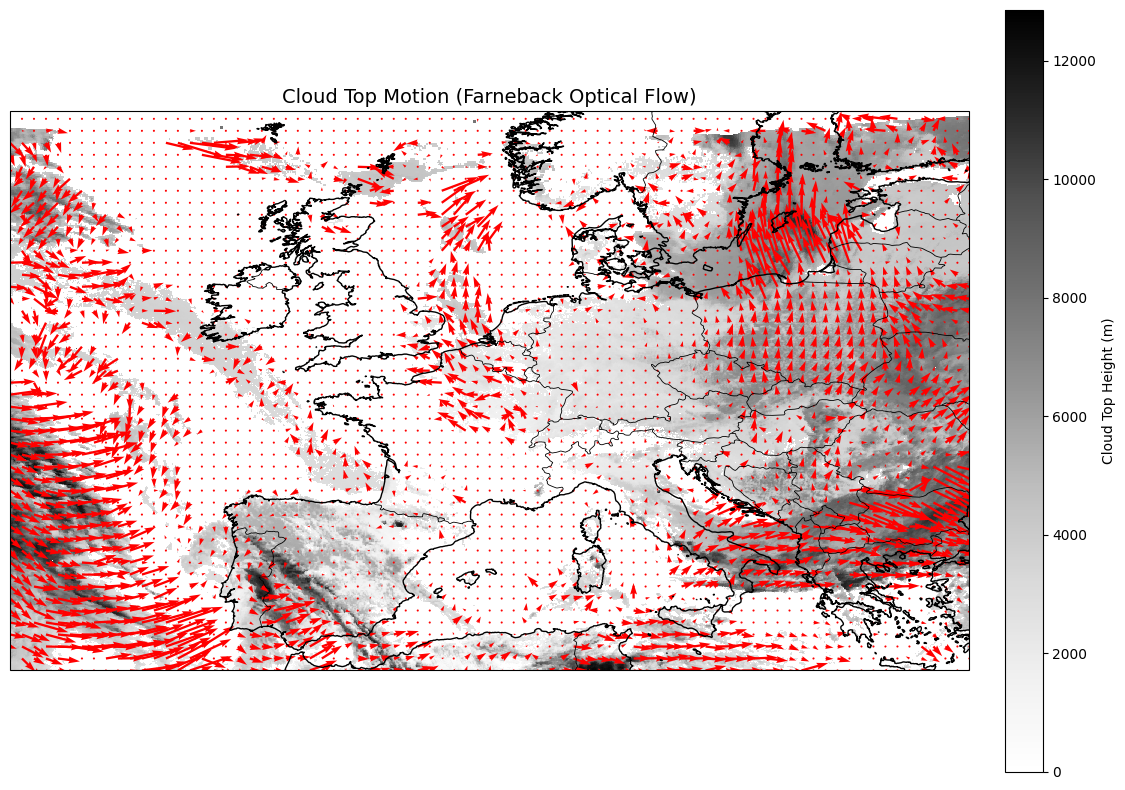

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import cv2

# --- Load CTH Frames ---
cth_dir = "cth_data"
nc_files = sorted([f for f in os.listdir(cth_dir) if f.endswith(".nc")])
path1 = os.path.join(cth_dir, nc_files[0])  # earlier
path2 = os.path.join(cth_dir, nc_files[1])  # later

ds1 = nc.Dataset(path1)
ds2 = nc.Dataset(path2)

cth1 = ds1.variables["CTH"][0, :, :]
cth2 = ds2.variables["CTH"][0, :, :]
lat = ds1.variables["lat"][:]
lon = ds1.variables["lon"][:]
ds1.close()
ds2.close()

lon2d, lat2d = np.meshgrid(lon, lat)

# --- Mask and Normalize ---
cth1_masked = np.ma.masked_where(cth1 <= 0, cth1).filled(0).astype(np.float32)
cth2_masked = np.ma.masked_where(cth2 <= 0, cth2).filled(0).astype(np.float32)

# Normalize to 0-255
img1_norm = cv2.normalize(cth1_masked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
img2_norm = cv2.normalize(cth2_masked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# --- Optical Flow using Farneback (fallback) ---
flow = cv2.calcOpticalFlowFarneback(
    img1_norm, img2_norm, None,
    pyr_scale=0.5, levels=3, winsize=15,
    iterations=3, poly_n=5, poly_sigma=1.2, flags=0
)

flow_u = flow[..., 0]
flow_v = -flow[..., 1]  # Flip Y for plotting

# --- Sampling Grid for Quiver ---
step = 20
y, x = np.meshgrid(
    np.arange(0, flow.shape[0], step),
    np.arange(0, flow.shape[1], step),
    indexing="ij"
)
u = flow_u[y, x]
v = flow_v[y, x]
lon_quiv = lon2d[y, x]
lat_quiv = lat2d[y, x]

# --- Plotting ---
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Background
bg = ax.pcolormesh(lon2d, lat2d, cth2_masked, cmap="Greys", shading="auto")

# Motion vectors
ax.quiver(lon_quiv, lat_quiv, u, v, color="red", scale=300)

# Features
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.set_title("Cloud Top Motion (Farneback Optical Flow)", fontsize=14)

# Colorbar
plt.colorbar(bg, label="Cloud Top Height (m)", pad=0.03)
plt.tight_layout()
plt.savefig("cth_motion_farneback.png", dpi=150)
plt.show()

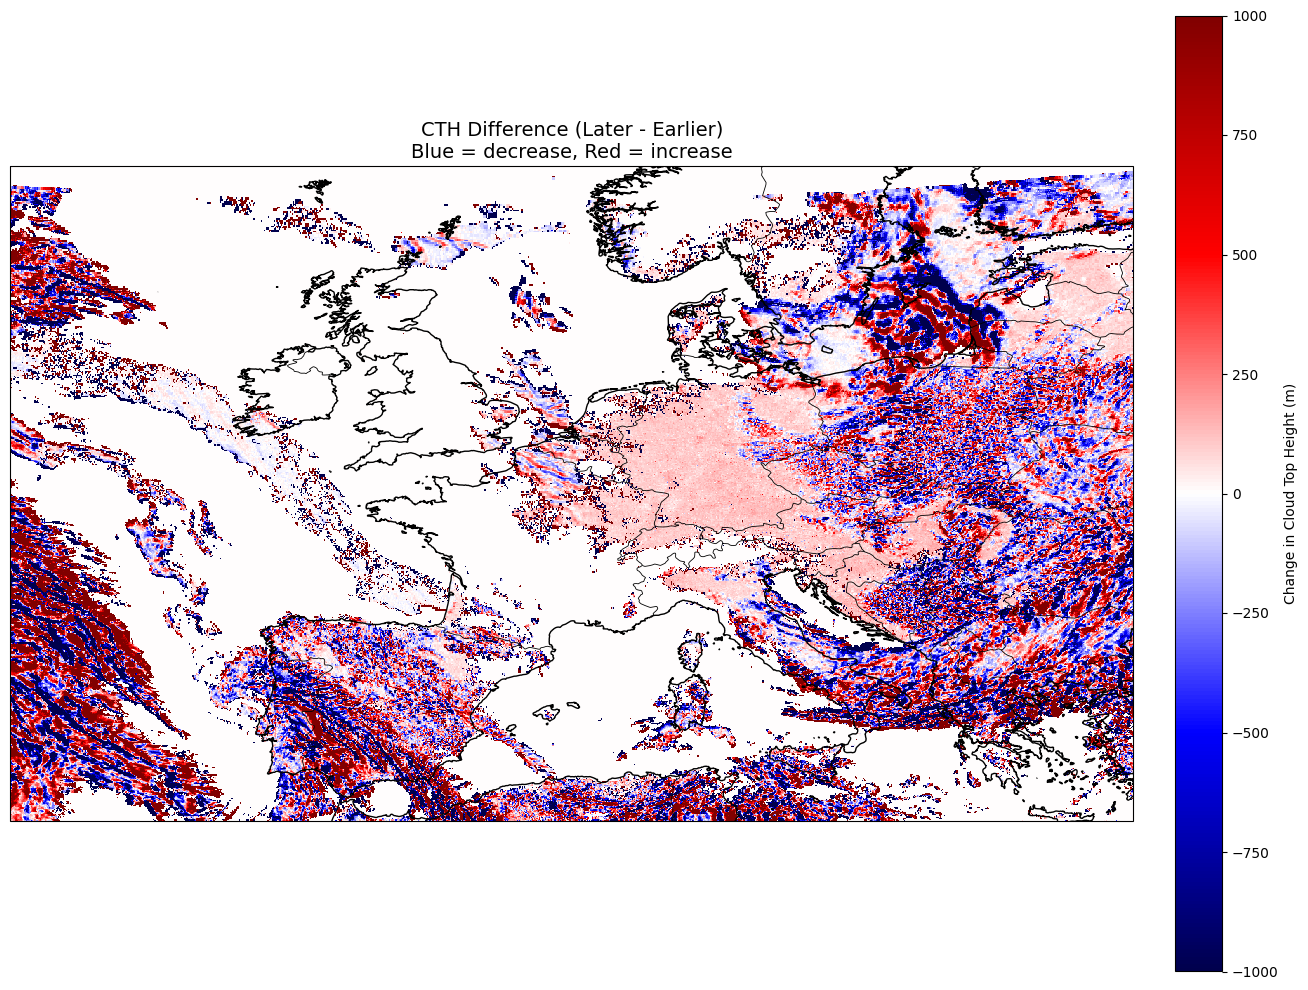

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Compute the difference
diff = img2 - img1  # later - earlier

# Set up map plot
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Plot difference with diverging colormap
im = ax.pcolormesh(lon2d, lat2d, diff, cmap="seismic", shading="auto", vmin=-1000, vmax=1000)

# Add features
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.set_title("CTH Difference (Later - Earlier)\nBlue = decrease, Red = increase", fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.03)
cbar.set_label("Change in Cloud Top Height (m)")

# Show and optionally save
plt.tight_layout()
plt.savefig("cth_difference_map.png", dpi=150)
plt.show()
